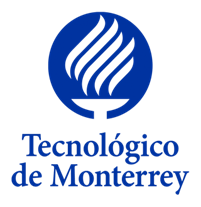

## TC 5033
### Text Generation
### Team Members:
- A01200230 - Armando Bringas Corpus

<br>

#### Activity 4: Building a Simple LSTM Text Generator using WikiText-2
<br>

- Objective:
    - Gain a fundamental understanding of Long Short-Term Memory (LSTM) networks.
    - Develop hands-on experience with sequence data processing and text generation in PyTorch. Given the simplicity of the model, amount of data, and computer resources, the text you generate will not replace ChatGPT, and results must likely will not make a lot of sense. Its only purpose is academic and to understand the text generation using RNNs.
    - Enhance code comprehension and documentation skills by commenting on provided starter code.
    
<br>

- Instructions:
    - Code Understanding: Begin by thoroughly reading and understanding the code. Comment each section/block of the provided code to demonstrate your understanding. For this, you are encouraged to add cells with experiments to improve your understanding

    - Model Overview: The starter code includes an LSTM model setup for sequence data processing. Familiarize yourself with the model architecture and its components. Once you are familiar with the provided model, feel free to change the model to experiment.

    - Training Function: Implement a function to train the LSTM model on the WikiText-2 dataset. This function should feed the training data into the model and perform backpropagation. 

    - Text Generation Function: Create a function that accepts starting text (seed text) and a specified total number of words to generate. The function should use the trained model to generate a continuation of the input text.

    - Code Commenting: Ensure that all the provided starter code is well-commented. Explain the purpose and functionality of each section, indicating your understanding.

    - Submission: Submit your Jupyter Notebook with all sections completed and commented. Include a markdown cell with the full names of all contributing team members at the beginning of the notebook.
    
<br>

- Evaluation Criteria:
    - Code Commenting (60%): The clarity, accuracy, and thoroughness of comments explaining the provided code. You are suggested to use markdown cells for your explanations.

    - Training Function Implementation (20%): The correct implementation of the training function, which should effectively train the model.

    - Text Generation Functionality (10%): A working function is provided in comments. You are free to use it as long as you make sure to uderstand it, you may as well improve it as you see fit. The minimum expected is to provide comments for the given function. 

    - Conclusions (10%): Provide some final remarks specifying the differences you notice between this model and the one used  for classification tasks. Also comment on changes you made to the model, hyperparameters, and any other information you consider relevant. Also, please provide 3 examples of generated texts.



In [1]:
import numpy as np
#PyTorch libraries
import torch
import torchtext
from torchtext.datasets import WikiText2
# Dataloader library
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from tqdm import tqdm

import random

# Added libraries
import math
import time

In [2]:
# Check torch version
torch.__version__

'2.1.0'

In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    print(torch.cuda.get_device_capability(0))
    print(torch.cuda.get_device_properties(0))
else:
    print("No GPU available")

NVIDIA GeForce GTX 1650
(7, 5)
_CudaDeviceProperties(name='NVIDIA GeForce GTX 1650', major=7, minor=5, total_memory=4095MB, multi_processor_count=14)


In [5]:
train_dataset, val_dataset, test_dataset = WikiText2()

In [6]:
tokeniser = get_tokenizer('basic_english')
def yield_tokens(data):
    for text in data:
        yield tokeniser(text)

In [7]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>", "<pad>", "<bos>", "<eos>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [8]:
seq_length = 50
def data_process(raw_text_iter, seq_length = 50):
    data = [torch.tensor(vocab(tokeniser(item)), dtype=torch.long) for item in raw_text_iter]
    data = torch.cat(tuple(filter(lambda t: t.numel() > 0, data))) #remove empty tensors
#     target_data = torch.cat(d)
    return (data[:-(data.size(0)%seq_length)].view(-1, seq_length), 
            data[1:-(data.size(0)%seq_length-1)].view(-1, seq_length))  

# # Create tensors for the training set
x_train, y_train = data_process(train_dataset, seq_length)
x_val, y_val = data_process(val_dataset, seq_length)
x_test, y_test = data_process(test_dataset, seq_length)

In [9]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

In [10]:
batch_size = 64  # choose a batch size that fits your computation resources
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [11]:
# Define the LSTM model
# Feel free to experiment
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.embedding_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # As regularization added dropout in LSTM and after as a layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.init_weights() # Added weight layer

    def forward(self, text, hidden=None):
        embeddings = self.embeddings(text)
        output, hidden = self.lstm(embeddings, hidden)
        # As regularization added droput in the output
        output = self.dropout(output)
        decoded = self.fc(output)
        return decoded, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))

    # Added initiallization weights
    def init_weights(self):
        initrange = 0.1
        # Initialize embeddings
        self.embeddings.weight.data.uniform_(-initrange, initrange)
        # Initialize the linear layer
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)
        # Initialization schemes for LSTM: https://pytorch.org/docs/stable/nn.init.html
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                # Glorot - input-hidden weights 
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                # Orthogonal - hidden-hidden weights
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                # Bias 
                param.data.fill_(0)

In [12]:
vocab_size = len(vocab) # vocabulary size
emb_size = 400 # embedding size
neurons = 512 # the dimension of the feedforward network model, i.e. # of neurons 
num_layers = 2 # the number of nn.LSTM layers
dropout_rate = 0.65 # the regularization factor

model = LSTMModel(vocab_size, emb_size, neurons, num_layers, dropout_rate)

In [13]:
def train(model, epochs, optimiser):
    '''
    The following are possible instructions you may want to conside for this function.
    This is only a guide and you may change add or remove whatever you consider appropriate
    as long as you train your model correctly.
        - loop through specified epochs [ok]
        - loop through dataloader [ok]
        - don't forget to zero grad! [ok]
        - place data (both input and target) in device [ok]
        - init hidden states e.g. hidden = model.init_hidden(batch_size) [ok]
        - run the model [ok]
        - compute the cost or loss [ok]
        - backpropagation [ok]
        - Update paratemers [ok]
        - Include print all the information you consider helpful
    
    '''
    # Assign model to current processing device
    model = model.to(device=device)
    
    # Start counting total training time
    total_start_time = time.time()
    
    # Iterate through epochs
    for epoch in range(epochs):
        # Start epoch timing
        start_time = time.time()
        
        # Put model on training mode
        model.train()
        
        total_loss = 0
        for i, (data, targets) in enumerate(train_loader):
            # Assign data to the correct device
            data = data.to(device=device, dtype=torch.int64)
            targets = targets.to(device=device, dtype=torch.int64)
            
            # Initialize hidden states
            batch_size = data.size(0)
            hidden = model.init_hidden(batch_size)
            hidden = tuple([each.data for each in hidden])
            
            # Calculate prediction scores, forward pass
            scores, hidden = model(data, hidden)
            
            # Calculate the loss
            scores = scores.view(-1, vocab_size)
            targets = targets.view(-1)
            loss = F.cross_entropy(scores, targets)
            total_loss += loss.item()
            
            # Perform backward pass and optimize
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
            # Print batch loss
            if i % 100 == 0:  # print every 100 batches
                print(f'Epoch {epoch}, Batch {i}, Loss {loss.item()}')
        
        # Calculate average loss and elapsed time for the epoch
        avg_loss = total_loss / len(train_loader)
        elapsed_time = time.time() - start_time
        
        # Print epoch loss and time
        print('\n' + '-' * 60)
        print(f'Epoch {epoch} completed with average loss {avg_loss:.4f} in {elapsed_time:.2f}s')
        print('-' * 60 + '\n')
    
    # Print total elapsed time for training
    total_elapsed_time = time.time() - total_start_time
    hours = total_elapsed_time // 3600
    minutes = (total_elapsed_time % 3600) // 60
    seconds = (total_elapsed_time % 3600) % 60
    
    # Print total time with hours, minutes and seconds
    print(f'Total training time: {int(hours)}h {int(minutes)}m {int(seconds)}s')

In [14]:
# Call the train function
loss_function = nn.CrossEntropyLoss()
lr = 0.001
epochs = 50
optimiser = optim.Adam(model.parameters(), lr=lr)
train(model, epochs, optimiser)

Epoch 0, Batch 0, Loss 10.26754379272461
Epoch 0, Batch 100, Loss 6.810540199279785
Epoch 0, Batch 200, Loss 6.568319320678711
Epoch 0, Batch 300, Loss 6.375680923461914
Epoch 0, Batch 400, Loss 6.357797622680664
Epoch 0, Batch 500, Loss 6.107759475708008
Epoch 0, Batch 600, Loss 6.2094011306762695

------------------------------------------------------------
Epoch 0 completed with average loss 6.5176 in 145.80s
------------------------------------------------------------

Epoch 1, Batch 0, Loss 6.070250034332275
Epoch 1, Batch 100, Loss 5.9882588386535645
Epoch 1, Batch 200, Loss 5.9419660568237305
Epoch 1, Batch 300, Loss 5.813576698303223
Epoch 1, Batch 400, Loss 5.82686710357666
Epoch 1, Batch 500, Loss 5.750176906585693
Epoch 1, Batch 600, Loss 5.743387222290039

------------------------------------------------------------
Epoch 1 completed with average loss 5.8673 in 145.38s
------------------------------------------------------------

Epoch 2, Batch 0, Loss 5.617806911468506
Epo

In [15]:
def generate_text(model, start_text, num_words, temperature=1.0):
    model.eval()
    
    # Tokenize the starting text and initialize the hidden state
    words = tokeniser(start_text)
    hidden = model.init_hidden(1)
    
    # Generate words one by one
    for _ in range(num_words):
        # Input tensor preparation
        input_indices = [vocab[word] for word in words[-1:]]  # get indices for the last word only
        x = torch.tensor([input_indices], dtype=torch.long, device=device)
        
        # Get predictions from model
        y_pred, hidden = model(x, hidden)
        
        # Vector of raw prediction score (logit), apply softmax with temperature
        last_word_logits = y_pred[0][-1]
        probabilities = F.softmax(last_word_logits / temperature, dim=0).detach().cpu().numpy()
        
        # Sample a word index from the probability distribution, append the generated word to the words list
        word_index = np.random.choice(len(vocab), p=probabilities)
        words.append(vocab.lookup_token(word_index))

    return ' '.join(words)

In [16]:
print(generate_text(model, start_text="I like", num_words=100))

i like the apollo , <unk> <unk> en <unk> from <unk> to 1611 . four distinguished his worship , there is not what the quality of god seems to have written the <unk> , israeli <unk> and other restoration inscriptions . some of these acts does not give sarnia songs with the accompanying name of the french island and <unk> from medieval kings . this contains small examples of collectively used as georgian <unk> , and honoring elijah <unk> , 27 trials , whatever malalas ' prayers , , for the <unk> front ) , or <unk> ( series alongside microphones )


In [17]:
print(generate_text(model, start_text="A cat", num_words=125))

my cat is black @-@ like <unk> . unfortunately , for instance , provided @-@ old white and purple juice <unk> . many of the victims states they be worth eaten as approximately 23 <unk> that is of 8 % . the children to <unk> and four degree receive stories who described the <unk> in myth , so they found much good actively of privacy and text in the very fashion goal , though he ' s ill ' like ' it wasn ' t . in the meantime , the production of its worldwide was ever not written . , for


In [18]:
print(generate_text(model, start_text="She loves you because", num_words=25))

she loves you because she wanted a new musical to <unk> , moving from it to a varied <unk> <unk> on the words yes being was <unk> . lady rosebery of an audience was able to admit that it was on right . the age of i did understand the freedom of it where he could not gain public topics and do not say the <unk> , except it simply it . his political involvement in the purge was an effort of news . however , relations with the country would not be granted until the incursion was discussed by louis @-@ foot (


In [19]:
print(generate_text(model, start_text="I hope", num_words=50))

i hope . turner explained , i think i hadn ' t adopted the cumulative video of the day when neither <unk> can be given and forever is love and his want , as is the song ' s ten – american title . n . <unk> claimed that my life is good with grace , but the case was destined to die . it ' s enough to perform you really want something to have been adventure , while <unk> dead plays , i ' m really making you ' re bit too , without everything i need to make you


In [20]:
print(generate_text(model, start_text="The Beatles are", num_words=250))

the beatles <unk> ( <unk> ) , drama ) dublin and themes of fame , and bungie ( 1994 ) , as their best @-@ lived albums of 2003 , all things called samples – 1992 . the songs chose to dominate the song in woodstock and country , which follows its background on the show ' s most different part of the show , but that it makes more erratic , too really in what me not ' her ' , i go as a <unk> deal , but in negative desert he couldn ' t play on our side to


In [21]:
print(generate_text(model, start_text="Super Mario is", num_words=175))

super mario is the oldest time to have altered a historical tradition or how it she is almost physically . it was only used as a threat place of the latin american empire when bertin successfully become emperor of his followers , leading to several archaeologists , who would outside the term wica as the mission to gifted high native , but it conveyed word insight over the growing importance of the anonymus period . while the corrector became <unk> of the sinai period , the victory included the river between ancient britain and <unk> – <unk> ad . later that year , murchad discovered buried shapur on assyria or mohammed . eusebius is dismissed as the ruler of sidon , and a <unk> of his wife would have been allowed as a beautiful ruler of the patriarch ' s son of the arabs of kingdom p . lawrence ' s <unk> <unk> ( sitriuc mac maíl ) during the 17th century , and <unk> declared gofraid as the <unk> of the kings of king ' s trilogy
